# RL Policy vs Threshold-Based Deflection Analysis

This notebook analyzes and compares the performance of the RL-based deflection policy against simple threshold-based deflection baselines. We will examine:

1. **Forward Queue Occupancy Trends** - How queue occupancy evolves over time
2. **Total Switch Queue Occupancy** - Overall congestion patterns across the switch
3. **Flow Completion Time (FCT) Analysis** - Mean and 95th percentile FCT performance

## Analysis Overview

- **RL Policy**: Learned deflection decisions using corrected normalization parameters
- **Threshold Baselines**: Simple threshold-based deflection at 15KB, 25KB, 37.5KB, and 50KB
- **Metrics**: Queue occupancy trends, FCT distributions, deflection rates

Let's start by loading the necessary libraries and data.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Define paths
rl_results_path = Path("/home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims")
threshold_results_path = Path("/home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims/results")
threshold_paths = {
    15000: threshold_results_path / "results_1G_thr_15000",
    25000: threshold_results_path / "results_1G_thr_25000",
    37500: threshold_results_path / "results_1G_thr_37500",
    50000: threshold_results_path / "results_1G_thr_50000"
}
ecmp_results_path = Path("/home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims/results_1G_dctcp_ecmp")

print("🔧 Setup complete!")
print(f"RL results path: {rl_results_path}")
print(f"Threshold results path: {threshold_results_path}")
print(f"ECMP results path: {ecmp_results_path}")
print(f"RL results exist: {rl_results_path.exists()}")
print(f"Threshold results exist: {threshold_results_path.exists()}")

🔧 Setup complete!
RL results path: /home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims/results_rl_policy
Threshold results path: /home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims/results
ECMP results path: /home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims/results_1G_dctcp_ecmp
RL results exist: True
Threshold results exist: True


In [2]:
import os 
import glob

def load_wide_csv_requester_id(folder: str, name: str):
    """Load RequesterID data from wide CSV format with multiple switches per file"""
    pattern = os.path.join(folder, '*.csv')
    files = sorted(glob.glob(pattern))
    if not files:
        return pd.DataFrame(columns=['timestamp', name])
    
    dfs = []
    for fp in files:
        try:
            print(f"Processing {os.path.basename(fp)} for {name}")
            
            # Read the CSV file
            df = pd.read_csv(fp)
            
            # The file has multiple columns representing different switches
            # Each pair of columns is (timestamp, RequesterID) for a specific switch
            data_rows = []
            
            # Process each row
            for idx, row in df.iterrows():
                # Extract timestamp,value pairs from each row
                # Skip first column (header info) and process in pairs
                row_values = row.values
                
                # Process pairs of columns: timestamp, value
                for i in range(0, len(row_values), 2):
                    if i + 1 < len(row_values):
                        try:
                            timestamp = pd.to_numeric(row_values[i], errors='coerce')
                            value = pd.to_numeric(row_values[i + 1], errors='coerce')
                            
                            if pd.notna(timestamp) and pd.notna(value):
                                data_rows.append([timestamp, value])
                        except:
                            continue
            
            if data_rows:
                dfi = pd.DataFrame(data_rows, columns=['timestamp', name])
                dfi = dfi.drop_duplicates().sort_values('timestamp').reset_index(drop=True)
                print(f"  Loaded {len(dfi)} {name} records")
                print(f"  Sample values: {sorted(dfi[name].unique())[:10]}")
                dfs.append(dfi)
                
        except Exception as e:
            print(f"Error processing {fp}: {e}")
            continue
    
    if not dfs:
        return pd.DataFrame(columns=['timestamp', name])
    
    out = pd.concat(dfs, ignore_index=True)
    out = out.drop_duplicates().sort_values('timestamp').reset_index(drop=True)
    return out

results_dir = rl_results_path
flow_started_df = load_wide_csv_requester_id(os.path.join(results_dir, 'FLOW_STARTED'), 'RequesterID')
flow_started_df.rename(columns={'timestamp': 'flow_start_time'}, inplace=True)
flow_ended_df = load_wide_csv_requester_id(os.path.join(results_dir, 'FLOW_ENDED'), 'RequesterID')
flow_ended_df.rename(columns={'timestamp': 'flow_end_time'}, inplace=True)
print("✓ Loaded RL flow start and end data")

# Load threshold flow data using load_wide_csv_requester_id
threshold_flow_data = {}
threshold_df_0 = load_wide_csv_requester_id(os.path.join(threshold_paths[15000], 'FLOW_ENDED'), 'RequesterID')
threshold_df_0.rename(columns={'timestamp': 'flow_end_time'}, inplace=True)
threshold_flow_data[15000] = threshold_df_0
threshold_df_1 = load_wide_csv_requester_id(os.path.join(threshold_paths[
25000], 'FLOW_ENDED'), 'RequesterID')
threshold_df_1.rename(columns={'timestamp': 'flow_end_time'}, inplace=True)
threshold_flow_data[25000] = threshold_df_1
threshold_df_2 = load_wide_csv_requester_id(os.path.join(threshold_paths[
37500], 'FLOW_ENDED'), 'RequesterID')
threshold_df_2.rename(columns={'timestamp': 'flow_end_time'}, inplace=True)
threshold_flow_data[37500] = threshold_df_2
threshold_df_3 = load_wide_csv_requester_id(os.path.join(threshold_paths[
50000], 'FLOW_ENDED'), 'RequesterID')
threshold_df_3.rename(columns={'timestamp': 'flow_end_time'}, inplace=True)
threshold_flow_data[50000] = threshold_df_3
print("✓ Loaded RL flow data")

# Load ECMP flow data using load_wide_csv_requester_id
ecmp_flow_data = {}
ecmp_df = load_wide_csv_requester_id(os.path.join(ecmp_results_path,
'FLOW_ENDED'), 'RequesterID')
ecmp_df.rename(columns={'timestamp': 'flow_end_time'}, inplace=True)
ecmp_flow_data['ECMP'] = ecmp_df
print("✓ Loaded ECMP flow data")

Processing rl_policy_8dc66ba9_4s_8a_40srv_rl_policy.csv for RequesterID


  Loaded 7250 RequesterID records
  Sample values: [100.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0]
Processing sim_688b2599_15000_deflection_threshold_15000.csv for RequesterID
  Loaded 6777 RequesterID records
  Sample values: [100.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0]
Processing sim_99ffc3ea_37500_deflection_threshold_37500.csv for RequesterID
  Loaded 7740 RequesterID records
  Sample values: [100.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0]
Processing sim_b7ca6d59_25000_deflection_threshold_25000.csv for RequesterID
  Loaded 7259 RequesterID records
  Sample values: [100.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0]
Processing sim_c2a2613f_50000_deflection_threshold_50000.csv for RequesterID
  Loaded 8086 RequesterID records
  Sample values: [100.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0]
Processing rl_policy_8dc66ba9_4s_8a_40srv_rl_policy.csv for RequesterID
  Loaded 4

In [3]:
def compute_fct(starts_df, ends_df, request_id_col='RequesterID',
                start_col='flow_start_time', end_col='flow_end_time'):
    # Prepare copies and ensure integer RequesterID
    starts = starts_df[[request_id_col, start_col]].copy()
    ends = ends_df[[request_id_col, end_col]].copy()

    starts[request_id_col] = starts[request_id_col].astype(np.int64)
    ends[request_id_col] = ends[request_id_col].astype(np.int64)

    # Aggregate per flow (RequesterID)
    start_times = starts.groupby(request_id_col, as_index=False)[start_col].min()
    end_times = ends.groupby(request_id_col, as_index=False)[end_col].max()

    # Join and compute FCT
    fct_df = pd.merge(start_times, end_times, on=request_id_col, how='inner')
    fct_df['fct'] = fct_df[end_col] - fct_df[start_col]

    # Keep valid FCTs (non-negative)
    fct_df = fct_df[fct_df['fct'] >= 0].reset_index(drop=True)
    return fct_df, start_times, end_times


# RL FCT
rl_fct_df, start_times, end_times = compute_fct(flow_started_df, flow_ended_df)

# Thresholds FCT
for thr, df in threshold_flow_data.items():
    thr_fct_df, _, _ = compute_fct(flow_started_df, df)
    threshold_flow_data[thr] = thr_fct_df

# ECMP FCT
ecmp_fct_df, _, _ = compute_fct(flow_started_df, df)

# Keep valid FCTs (non-negative)
rl_fct_df = rl_fct_df[rl_fct_df['fct'] >= 0].reset_index(drop=True)

IndexError: cannot do a non-empty take from an empty axes.

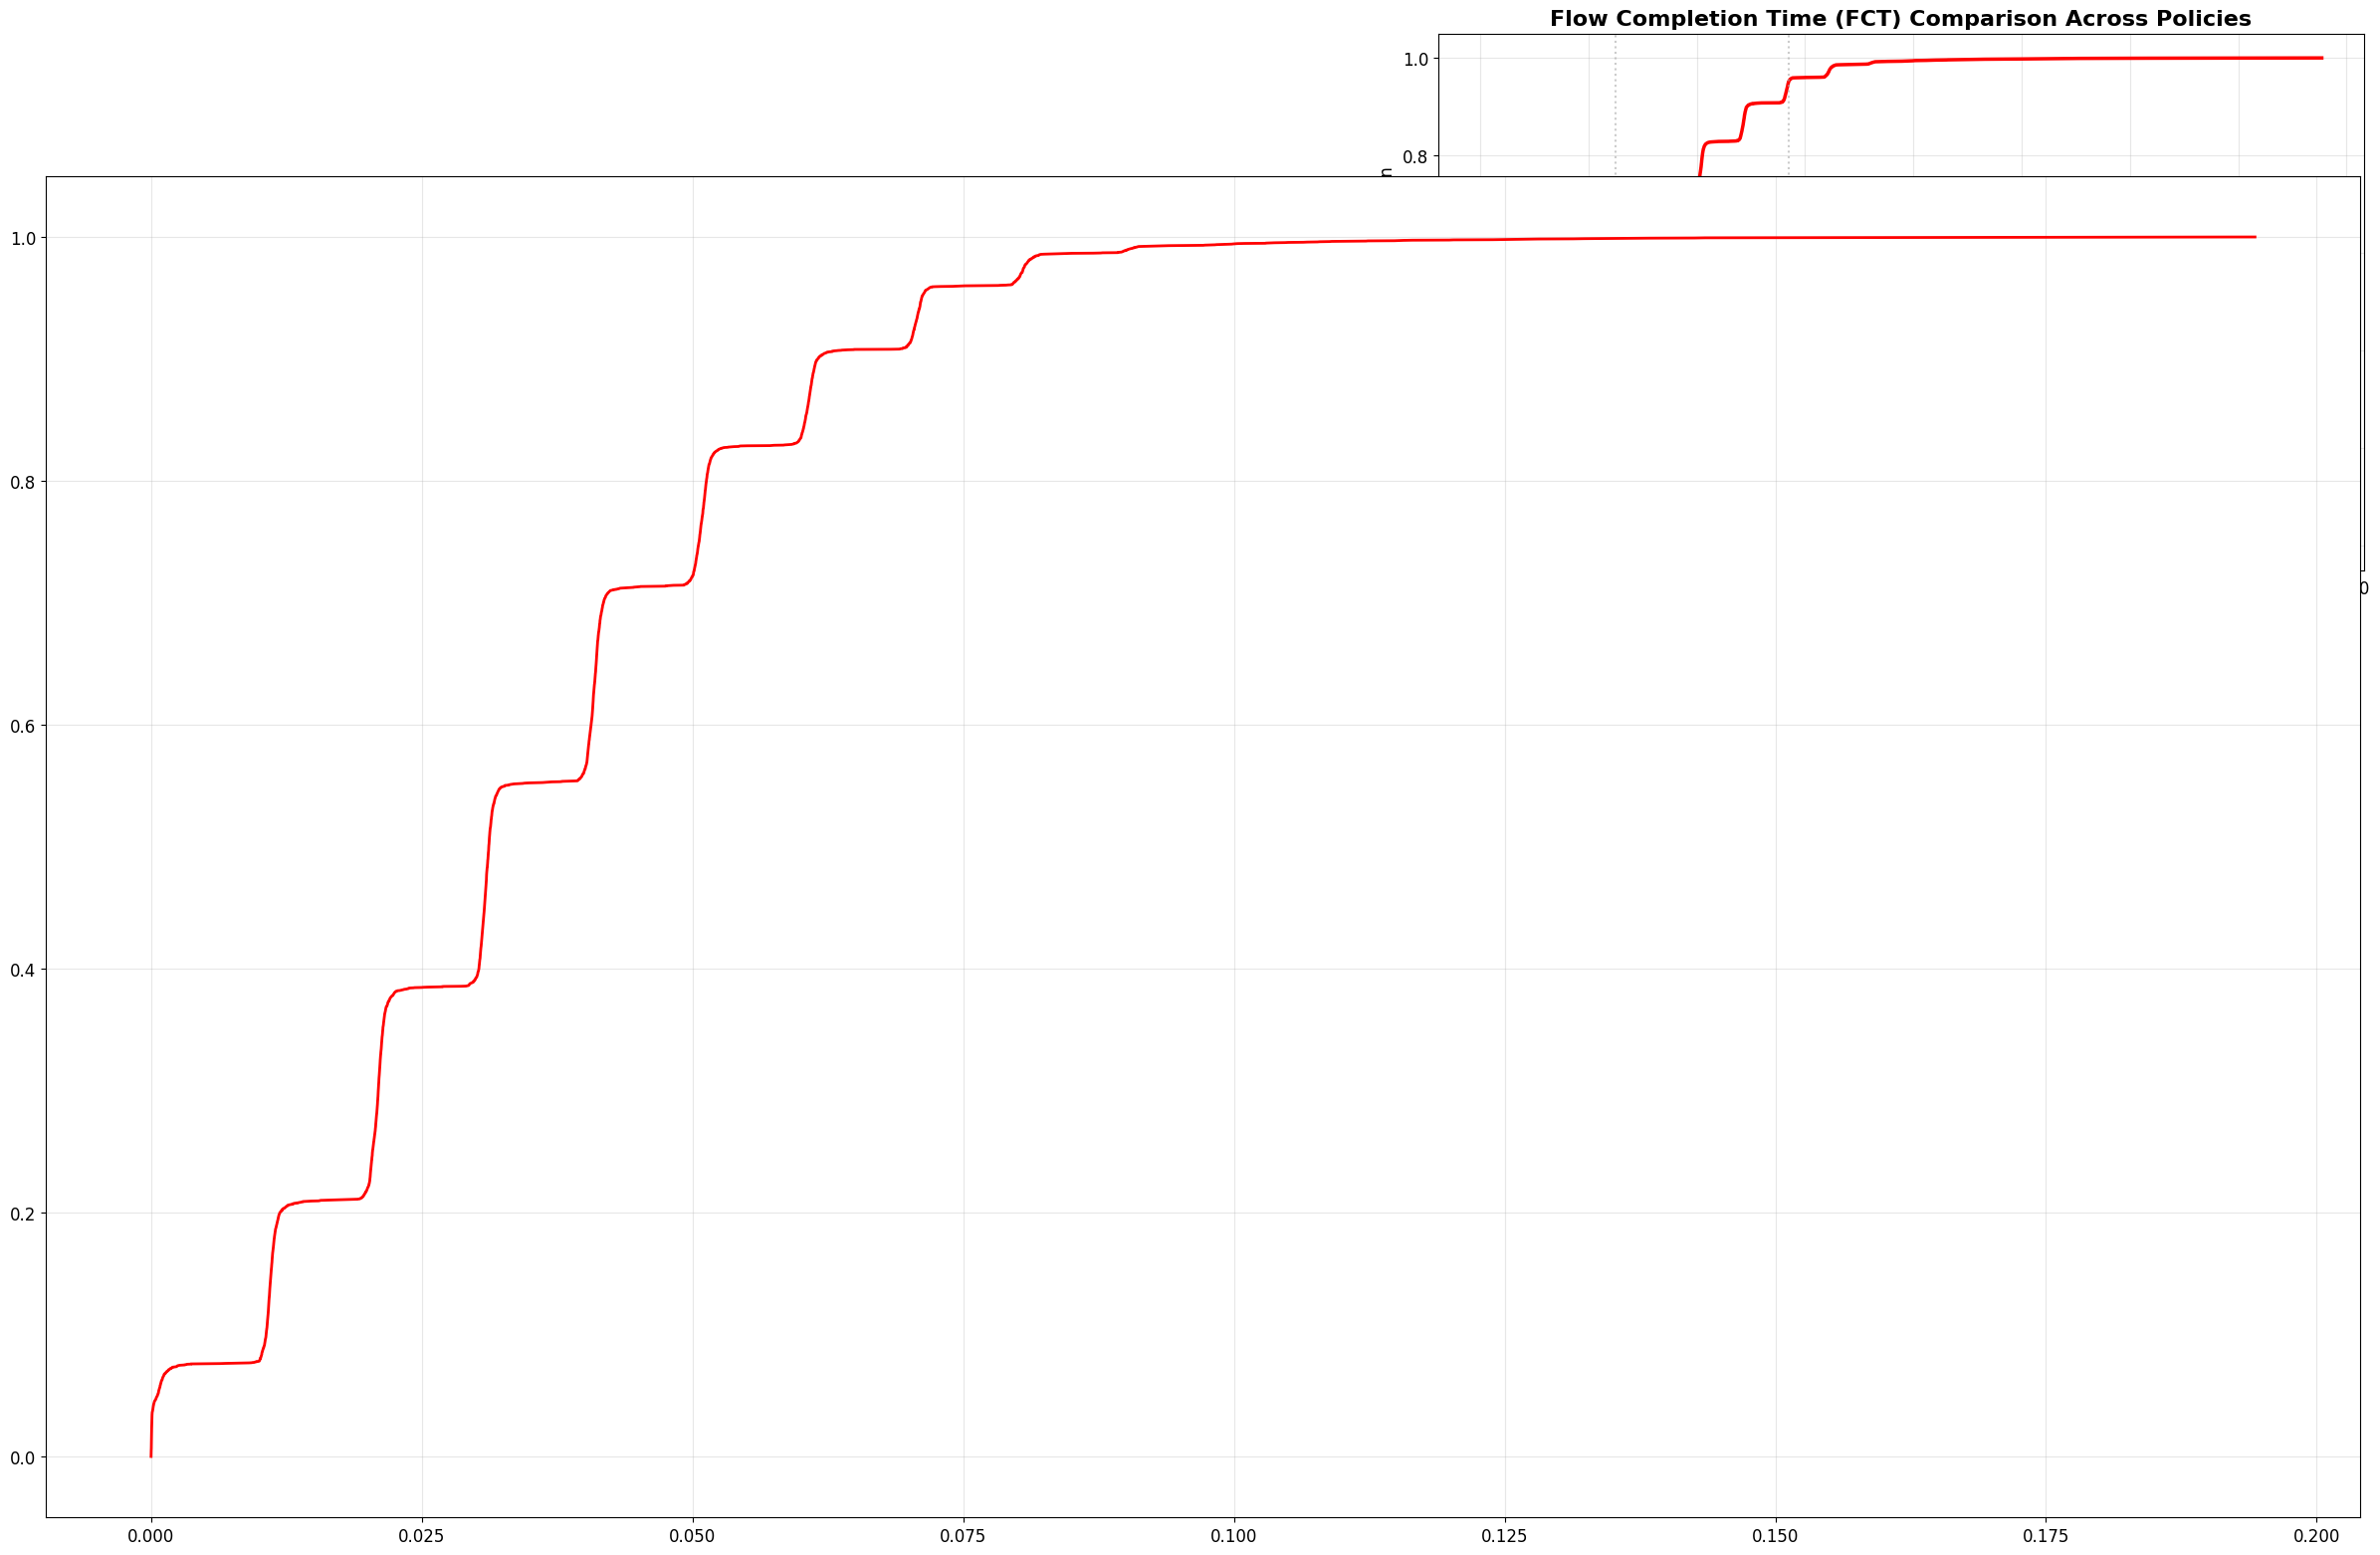

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

def compute_cdf(data):
    """Compute CDF values for given data"""
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Create a comprehensive FCT comparison plot
plt.figure(figsize=(12, 7))

# Get data for all policies
rl_fcts = rl_fct_df['fct'].values
ecmp_fcts = ecmp_fct_df['fct'].values

# Set up colors for better distinction
colors = {
    'RL': 'red',
    'ECMP': 'black',
    15000: '#1f77b4',  # blue
    25000: '#2ca02c',  # green
    37500: '#ff7f0e',  # orange
    50000: '#9467bd'   # purple
}

# Plot RL Policy
rl_sorted, rl_cdf = compute_cdf(rl_fcts)
plt.plot(rl_sorted, rl_cdf, label='RL Policy', 
         linewidth=2.5, color=colors['RL'], linestyle='-')

# Plot ECMP
ecmp_sorted, ecmp_cdf = compute_cdf(ecmp_fcts)
plt.plot(ecmp_sorted, ecmp_cdf, label='ECMP', 
         linewidth=2, color=colors['ECMP'], linestyle=':')

# Plot all threshold policies
for threshold, df in sorted(threshold_flow_data.items()):
    if 'fct' in df.columns:
        thr_fcts = df['fct'].values
        thr_sorted, thr_cdf = compute_cdf(thr_fcts)
        plt.plot(thr_sorted, thr_cdf, 
                 label=f'Threshold {threshold}', 
                 linewidth=1.5, color=colors[threshold], 
                 linestyle='--')

# Add reference lines for percentiles
p50_rl = np.percentile(rl_fcts, 50)
p95_rl = np.percentile(rl_fcts, 95)
plt.axvline(p50_rl, color='darkgray', linestyle=':', alpha=0.6)
plt.axvline(p95_rl, color='darkgray', linestyle=':', alpha=0.6)
plt.text(p50_rl, 0.2, f'P50 RL: {p50_rl:.4f}s', rotation=90, color='darkgray')
plt.text(p95_rl, 0.2, f'P95 RL: {p95_rl:.4f}s', rotation=90, color='darkgray')

# Add annotations
plt.title('Flow Completion Time (FCT) Comparison Across Policies', fontsize=16, fontweight='bold')
plt.xlabel('Flow Completion Time (seconds)', fontsize=12)
plt.ylabel('Cumulative Distribution Function', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)

# Add an inset for the tail of the distribution
axins = zoomed_inset_axes(plt.gca(), 2.5, bbox_to_anchor=(1.005, 0.75), bbox_transform=plt.gca().transAxes)

# Plot data in the inset
axins.plot(rl_sorted, rl_cdf, linewidth=2, color=colors['RL'])
axins.plot(ecmp_sorted, ecmp_cdf, linewidth=1.5, color=colors['ECMP'], linestyle=':')

for threshold, df in sorted(threshold_flow_data.items()):
    if 'fct' in df.columns:
        thr_fcts = df['fct'].values
        thr_sorted, thr_cdf = compute_cdf(thr_fcts)
        axins.plot(thr_sorted, thr_cdf, linewidth=1, color=colors[threshold], linestyle='--')

# Set the limits for the inset - focus on 90th+ percentile
x_min = min(np.percentile(rl_fcts, 90), np.percentile(ecmp_fcts, 90))
x_max = max(np.percentile(rl_fcts, 99.5), np.percentile(ecmp_fcts, 99.5))
axins.set_xlim(x_min, x_max)
axins.set_ylim(0.9, 1.0)
axins.grid(True, alpha=0.3)
axins.set_title('Tail Performance (90-99.5th percentile)', fontsize=10)

# Add connecting lines to show the zoomed region
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

# Print summary of improvements
print("\n=== FCT Improvement Analysis ===")
print(f"RL median FCT: {np.median(rl_fcts):.6f}s")
print(f"ECMP median FCT: {np.median(ecmp_fcts):.6f}s")
print(f"RL vs ECMP median improvement: {(np.median(ecmp_fcts)/np.median(rl_fcts)-1)*100:.2f}%")

print(f"\nRL 95th percentile: {np.percentile(rl_fcts, 95):.6f}s")
print(f"ECMP 95th percentile: {np.percentile(ecmp_fcts, 95):.6f}s")
print(f"RL vs ECMP 95th percentile improvement: {(np.percentile(ecmp_fcts, 95)/np.percentile(rl_fcts, 95)-1)*100:.2f}%")

In [ ]:
# Data loading functions (refactored with a common loader)

def _standardize_columns(df, kind, policy):
    """Standardize column names depending on kind and policy."""
    if df is None or df.empty:
        return df

    if kind == 'packet_actions':
        if policy in ('rl', 'ecmp'):
            if df.shape[1] >= 2:
                cols = list(df.columns)
                cols[0], cols[1] = 'timestamp', 'actions'
                df.columns = cols
        elif policy == 'threshold':
            # Ensure timestamp exists; keep other cols as-is (might contain 'result')
            if 'timestamp' not in df.columns and df.shape[1] > 0:
                df.rename(columns={df.columns[0]: 'timestamp'}, inplace=True)
    elif kind == 'queue_len':
        # Ensure timestamp and queueLength are present consistently
        if 'timestamp' not in df.columns and df.shape[1] >= 1:
            df.rename(columns={df.columns[0]: 'timestamp'}, inplace=True)
        if 'queueLength' not in df.columns and df.shape[1] >= 2:
            # Try to set second column to queueLength if not named already
            second = [c for c in df.columns if c != 'timestamp'][0]
            df.rename(columns={second: 'queueLength'}, inplace=True)
    return df

def _read_first_csv(dir_path, pattern):
    files = sorted(dir_path.glob(pattern))
    if not files:
        return None, None
    df = pd.read_csv(files[0])
    return df, files[0].name

def load_policy_results(base_dir, label='Policy', policy='generic',
                        packet_glob='*.csv', queue_glob='*.csv', flow_glob='*.csv'):
    """Generic loader for PACKET_ACTION, QUEUE_LEN and REQUESTER_ID."""
    data = {}
    if not base_dir.exists():
        print(f"⚠️ {label}: path does not exist -> {base_dir}")
        return data

    # PACKET_ACTION
    packet_dir = base_dir / "PACKET_ACTION"
    pdf, pfile = _read_first_csv(packet_dir, packet_glob) if packet_dir.exists() else (None, None)
    if pdf is not None:
        pdf = _standardize_columns(pdf, 'packet_actions', policy)
        data['packet_actions'] = pdf
        print(f"✓ Loaded {label} packet actions: {len(pdf)} entries from {pfile}")
    else:
        print(f"⚠️ No {label} packet action files found!")

    # QUEUE_LEN
    queue_dir = base_dir / "QUEUE_LEN"
    qdf, qfile = _read_first_csv(queue_dir, queue_glob) if queue_dir.exists() else (None, None)
    if qdf is not None:
        qdf = _standardize_columns(qdf, 'queue_len', policy)
        data['queue_len'] = qdf
        print(f"✓ Loaded {label} queue length: {len(qdf)} entries from {qfile}")
    else:
        print(f"⚠️ No {label} queue length files found!")

    return data

def load_rl_results():
    """Load RL policy results using the common loader."""
    return load_policy_results(
        rl_results_path,
        label='RL',
        policy='rl',
        packet_glob='*rl_policy*.csv',
        queue_glob='*rl_policy*.csv',
        flow_glob='*rl_policy*.csv'
    )

def load_ecmp_results():
    """Load ECMP results using the common loader."""
    return load_policy_results(
        ecmp_results_path,
        label='ECMP',
        policy='ecmp',
        packet_glob='*.csv',
        queue_glob='*.csv',
        flow_glob='*.csv'
    )

def load_threshold_results():
    """Load threshold-based results for all configured thresholds using the common loader."""
    threshold_data = {}
    for threshold, base_dir in threshold_paths.items():
        label = f"threshold {threshold}"
        if not base_dir.exists():
            print(f"⚠️ {label}: path does not exist -> {base_dir}")
            threshold_data[threshold] = {}
            continue

        data = load_policy_results(
            base_dir,
            label=label,
            policy='threshold',
            packet_glob='*.csv',
            queue_glob='*.csv',
            flow_glob='*.csv'
        )

        if data:
            threshold_data[threshold] = data
            print(f"✓ {label} loaded successfully: "
                  f"{len(data.get('packet_actions', []))} actions, "
                  f"{len(data.get('queue_len', []))} queue samples, "
                  f"{len(data.get('flow_ended', []))} flows")
        else:
            threshold_data[threshold] = {}
            print(f"⚠️ No data found for {label} in {base_dir}")
    return threshold_data
# Load all data
print("Loading experimental data...")
rl_data = load_rl_results()
threshold_data = load_threshold_results()
ecmp_data = load_ecmp_results()
print("Data loading complete!")

Loading experimental data...
✓ Loaded RL packet actions: 2591598 entries from rl_policy_8dc66ba9_4s_8a_40srv_rl_policy.csv
✓ Loaded RL queue length: 1295799 entries from rl_policy_8dc66ba9_4s_8a_40srv_rl_policy.csv
✓ Loaded RL packet actions: 2591598 entries from rl_policy_8dc66ba9_4s_8a_40srv_rl_policy.csv
✓ Loaded RL queue length: 1295799 entries from rl_policy_8dc66ba9_4s_8a_40srv_rl_policy.csv


✓ Loaded threshold 15000 packet actions: 1126104 entries from sim_688b2599_15000_deflection_threshold_15000.csv
✓ Loaded threshold 15000 queue length: 1126104 entries from sim_688b2599_15000_deflection_threshold_15000.csv
✓ threshold 15000 loaded successfully: 1126104 actions, 1126104 queue samples, 0 flows
✓ Loaded threshold 25000 packet actions: 1207944 entries from sim_b7ca6d59_25000_deflection_threshold_25000.csv
✓ Loaded threshold 25000 queue length: 1207944 entries from sim_b7ca6d59_25000_deflection_threshold_25000.csv
✓ threshold 25000 loaded successfully: 1207944 actions, 1207944 queue samples, 0 flows
✓ Loaded threshold 25000 packet actions: 1207944 entries from sim_b7ca6d59_25000_deflection_threshold_25000.csv
✓ Loaded threshold 25000 queue length: 1207944 entries from sim_b7ca6d59_25000_deflection_threshold_25000.csv
✓ threshold 25000 loaded successfully: 1207944 actions, 1207944 queue samples, 0 flows
✓ Loaded threshold 37500 packet actions: 1260879 entries from sim_99ffc3e

Total packets: 2,591,598
Deflected packets: 673,715
Deflection rate: 26.00%

Sample of deflected packets:
     timestamp  actions
778   0.000742        1
796   0.000751        1
797   0.000751        1
808   0.000755        1
822   0.000763        1

Deflected packets: 673,715
Deflection rate: 26.00%

Sample of deflected packets:
     timestamp  actions
778   0.000742        1
796   0.000751        1
797   0.000751        1
808   0.000755        1
822   0.000763        1


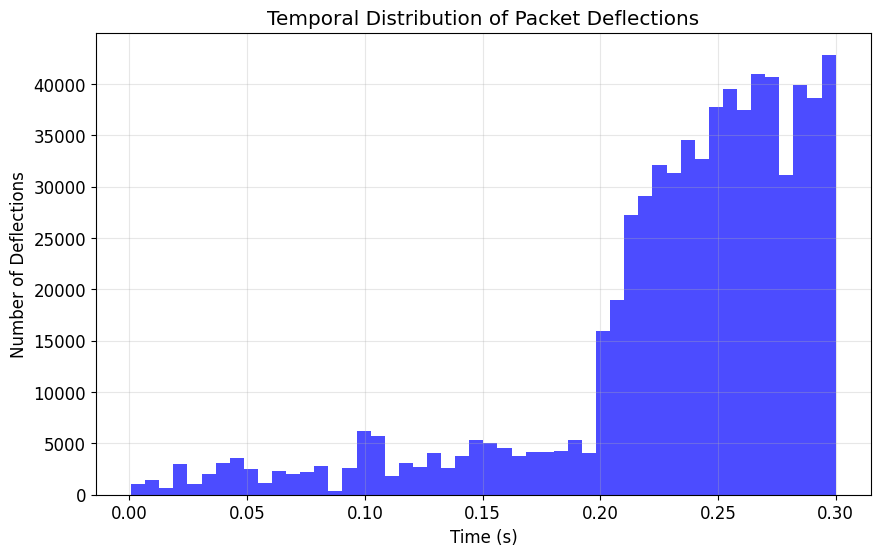

In [ ]:
# Filter out only the deflected packets (action = 1)
deflected_packets = rl_data['packet_actions'][rl_data['packet_actions'].iloc[:, 1] == 1]

# Calculate deflection statistics
total_packets = len(rl_data['packet_actions'])
deflected_count = len(deflected_packets)
deflection_rate = (deflected_count / total_packets) * 100

print(f"Total packets: {total_packets:,}")
print(f"Deflected packets: {deflected_count:,}")
print(f"Deflection rate: {deflection_rate:.2f}%")

# Display sample of deflected packets
print("\nSample of deflected packets:")
print(deflected_packets.head())

# Analyze temporal distribution of deflections
# Extract timestamp from the first column
# The first column has a long name but contains time values
first_col_name = deflected_packets.columns[0]

# Create a copy with a renamed column for better readability
deflected_packets_plot = deflected_packets.copy()
deflected_packets_plot.rename(columns={first_col_name: 'timestamp'}, inplace=True)

# Plot temporal distribution of deflections
plt.figure(figsize=(10, 6))
plt.hist(deflected_packets_plot['timestamp'], bins=50, alpha=0.7, color='blue')
plt.title('Temporal Distribution of Packet Deflections')
plt.xlabel('Time (s)')
plt.ylabel('Number of Deflections')
plt.grid(alpha=0.3)
plt.show()

🔍 Analyzing deflection rates...
🤖 RL Policy: 673,715 deflections / 2,591,598 decisions = 26.00%
📊 Threshold 15000: 320,148 deflections / 1,126,104 decisions = 28.43%
📊 Threshold 25000: 321,621 deflections / 1,207,944 decisions = 26.63%
📊 Threshold 37500: 314,932 deflections / 1,260,879 decisions = 24.98%
📊 Threshold 50000: 297,222 deflections / 1,272,895 decisions = 23.35%


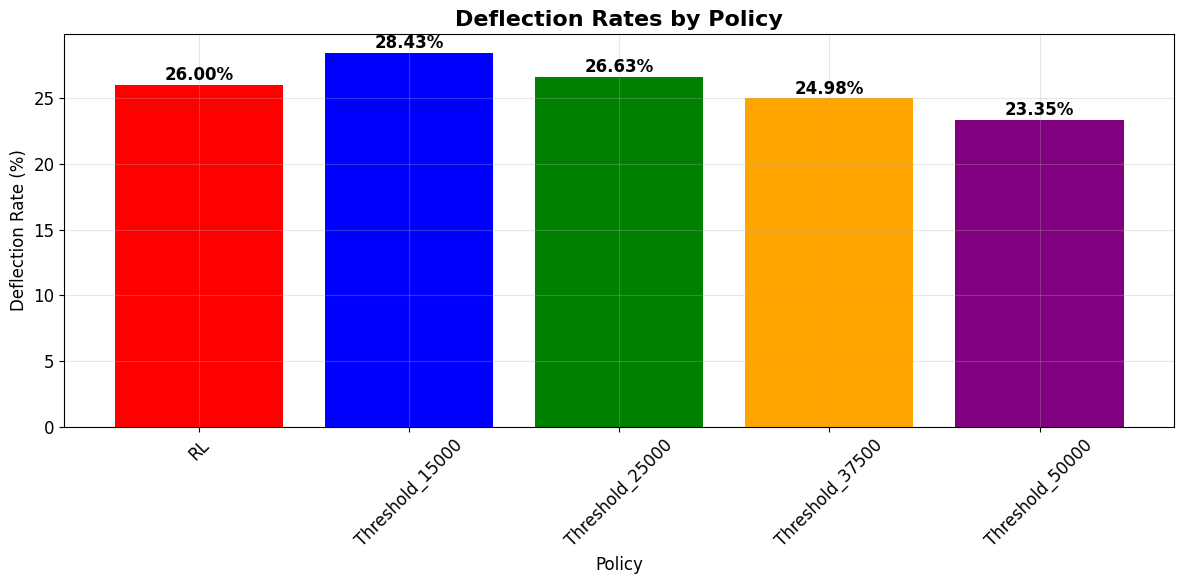

In [ ]:
# Deflection rate analysis
def analyze_deflection_rates(rl_data, threshold_data):
    """Calculate and compare deflection rates across all policies."""
    results = {}
    
    # RL policy deflection rate
    if 'packet_actions' in rl_data:
        rl_actions = rl_data['packet_actions']
        rl_total = len(rl_actions)
        rl_deflections = len(rl_actions[rl_actions.iloc[:, 1] == 1])
        rl_rate = (rl_deflections / rl_total) * 100 if rl_total > 0 else 0
        results['RL'] = {
            'rate': rl_rate,
            'deflections': rl_deflections,
            'total': rl_total
        }
        print(f"🤖 RL Policy: {rl_deflections:,} deflections / {rl_total:,} decisions = {rl_rate:.2f}%")
    
    # Threshold policies deflection rates
    for threshold, data in threshold_data.items():
        if 'packet_actions' in data:
            actions = data['packet_actions']
            total = len(actions)
            action_col = 'actions' if 'actions' in actions.columns else actions.columns[1]
            deflections = (actions[action_col] == 1).sum()
            rate = (deflections / total) * 100 if total > 0 else 0
            results[f'Threshold_{threshold}'] = {
                'rate': rate,
                'deflections': deflections,
                'total': total
            }
            print(f"📊 Threshold {threshold}: {deflections:,} deflections / {total:,} decisions = {rate:.2f}%")
    
    return results

def plot_deflection_comparison(deflection_results):
    """Create bar chart comparing deflection rates."""
    policies = list(deflection_results.keys())
    rates = [deflection_results[policy]['rate'] for policy in policies]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(policies, rates, color=['red', 'blue', 'green', 'orange', 'purple'])
    plt.title('Deflection Rates by Policy', fontsize=16, fontweight='bold')
    plt.xlabel('Policy', fontsize=12)
    plt.ylabel('Deflection Rate (%)', fontsize=12)
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, rate in zip(bars, rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run deflection analysis
print("🔍 Analyzing deflection rates...")
deflection_results = analyze_deflection_rates(rl_data, threshold_data)
plot_deflection_comparison(deflection_results)

📈 Analyzing queue occupancy patterns...
RL queue data shape: (1295799, 2)
RL queue columns: ['timestamp', 'queueLength']
🤖 RL Queue Stats - Mean: 33849.0, Max: 328512.0, P95: 109920.0
📊 Threshold 15000 Queue Stats - Mean: 8008.2, Max: 183408.0, P95: 36432.0
📊 Threshold 25000 Queue Stats - Mean: 14003.2, Max: 194304.0, P95: 37680.0
📊 Threshold 37500 Queue Stats - Mean: 20178.9, Max: 158528.0, P95: 49200.0
📊 Threshold 50000 Queue Stats - Mean: 26167.4, Max: 352176.0, P95: 61344.0
🤖 RL Queue Stats - Mean: 33849.0, Max: 328512.0, P95: 109920.0
📊 Threshold 15000 Queue Stats - Mean: 8008.2, Max: 183408.0, P95: 36432.0
📊 Threshold 25000 Queue Stats - Mean: 14003.2, Max: 194304.0, P95: 37680.0
📊 Threshold 37500 Queue Stats - Mean: 20178.9, Max: 158528.0, P95: 49200.0
📊 Threshold 50000 Queue Stats - Mean: 26167.4, Max: 352176.0, P95: 61344.0


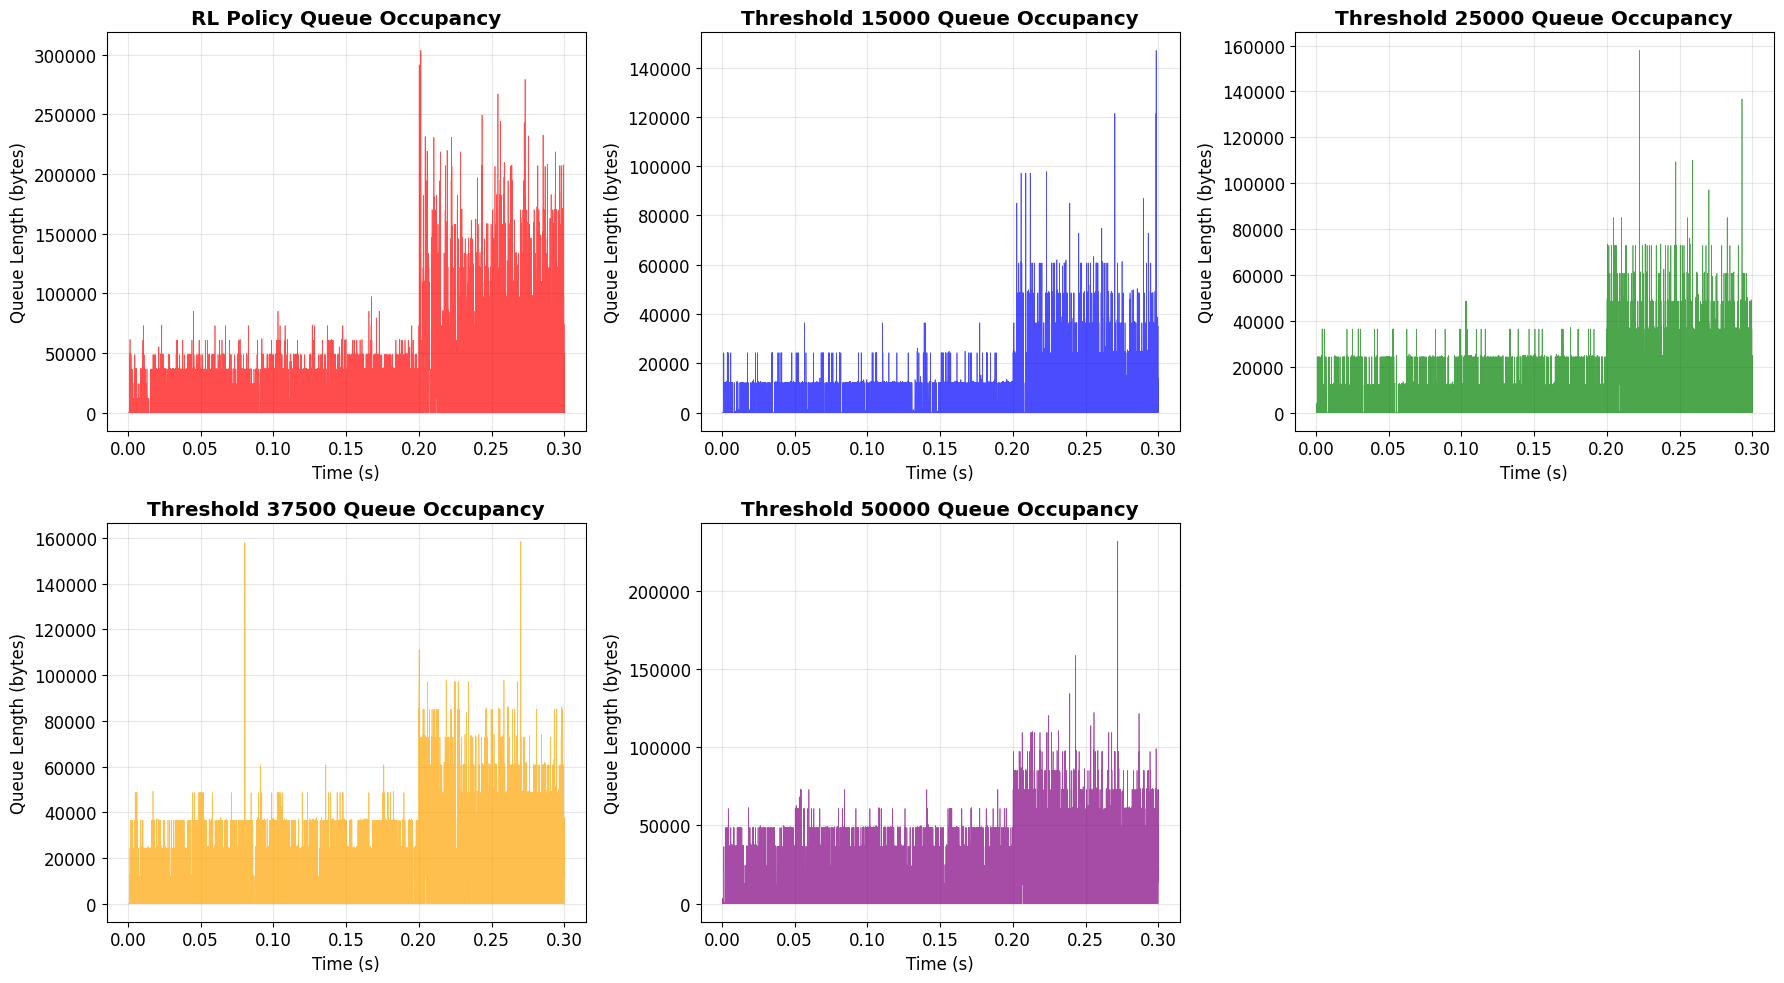

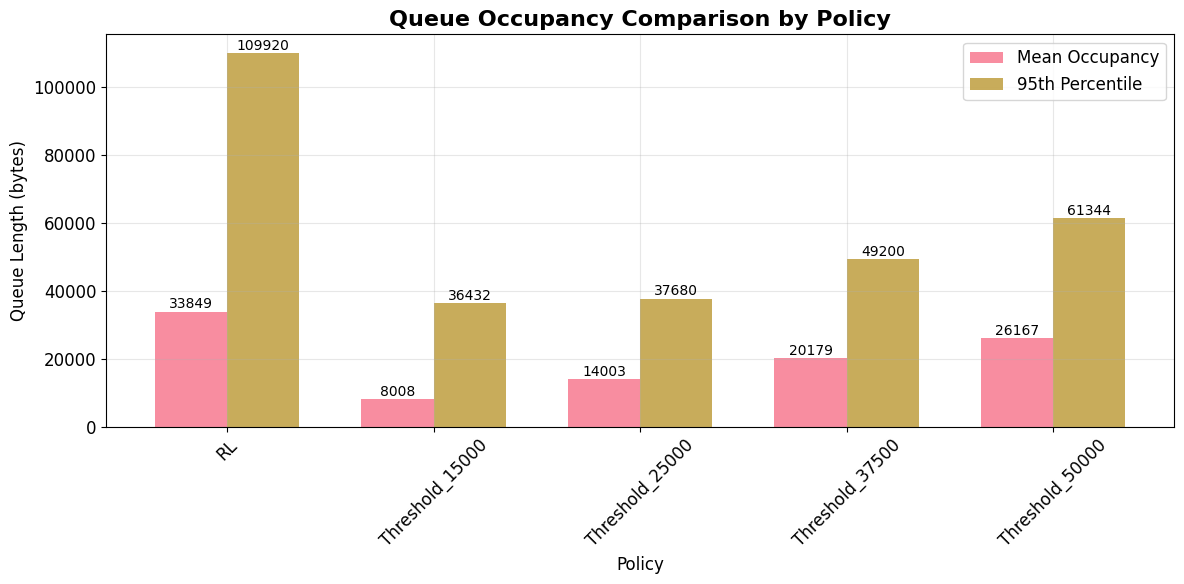

In [ ]:
# Queue occupancy analysis
def analyze_queue_occupancy(rl_data, threshold_data):
    """Analyze queue occupancy patterns across policies."""
    occupancy_stats = {}
    
    # RL policy queue analysis
    if 'queue_len' in rl_data:
        rl_queue = rl_data['queue_len']
        print(f"RL queue data shape: {rl_queue.shape}")
        print(f"RL queue columns: {rl_queue.columns.tolist()}")
        
        # Handle the queue length column - it might be the second column
        queue_col = 'queueLength' if 'queueLength' in rl_queue.columns else rl_queue.columns[1]
        queue_values = rl_queue[queue_col]
        
        # Convert to numpy array if needed to handle multi-dimensional indexing
        if hasattr(queue_values, 'values'):
            queue_values = queue_values.values.flatten()
        
        occupancy_stats['RL'] = {
            'mean_occupancy': float(np.mean(queue_values)),
            'max_occupancy': float(np.max(queue_values)),
            'std_occupancy': float(np.std(queue_values)),
            'p95_occupancy': float(np.percentile(queue_values, 95))
        }
        print(f"🤖 RL Queue Stats - Mean: {occupancy_stats['RL']['mean_occupancy']:.1f}, "
              f"Max: {occupancy_stats['RL']['max_occupancy']}, "
              f"P95: {occupancy_stats['RL']['p95_occupancy']:.1f}")
    
    # Threshold policies queue analysis
    for threshold, data in threshold_data.items():
        if 'queue_len' in data:
            queue_data = data['queue_len']
            queue_col = 'queueLength' if 'queueLength' in queue_data.columns else queue_data.columns[1]
            queue_values = queue_data[queue_col]
            
            if hasattr(queue_values, 'values'):
                queue_values = queue_values.values.flatten()
            
            occupancy_stats[f'Threshold_{threshold}'] = {
                'mean_occupancy': float(np.mean(queue_values)),
                'max_occupancy': float(np.max(queue_values)),
                'std_occupancy': float(np.std(queue_values)),
                'p95_occupancy': float(np.percentile(queue_values, 95))
            }
            print(f"📊 Threshold {threshold} Queue Stats - "
                  f"Mean: {occupancy_stats[f'Threshold_{threshold}']['mean_occupancy']:.1f}, "
                  f"Max: {occupancy_stats[f'Threshold_{threshold}']['max_occupancy']}, "
                  f"P95: {occupancy_stats[f'Threshold_{threshold}']['p95_occupancy']:.1f}")
    
    return occupancy_stats

def plot_queue_occupancy_trends(rl_data, threshold_data):
    """Plot queue occupancy over time for all policies."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot RL policy
    if 'queue_len' in rl_data:
        rl_queue = rl_data['queue_len']
        
        # Get timestamp and queue length columns
        time_col = 'timestamp' if 'timestamp' in rl_queue.columns else rl_queue.columns[0]
        queue_col = 'queueLength' if 'queueLength' in rl_queue.columns else rl_queue.columns[1]
        
        # Convert to numpy arrays to avoid multi-dimensional indexing issues
        timestamps = np.array(rl_queue[time_col]).flatten()
        queue_lengths = np.array(rl_queue[queue_col]).flatten()
        
        # Sample data if too many points (for better visualization)
        if len(timestamps) > 10000:
            step = len(timestamps) // 10000
            timestamps = timestamps[::step]
            queue_lengths = queue_lengths[::step]
        
        axes[plot_idx].plot(timestamps, queue_lengths, 
                           color='red', alpha=0.7, linewidth=0.5)
        axes[plot_idx].set_title('RL Policy Queue Occupancy', fontweight='bold')
        axes[plot_idx].set_xlabel('Time (s)')
        axes[plot_idx].set_ylabel('Queue Length (bytes)')
        axes[plot_idx].grid(alpha=0.3)
        plot_idx += 1
    
    # Plot threshold policies
    colors = ['blue', 'green', 'orange', 'purple']
    for i, (threshold, data) in enumerate(threshold_data.items()):
        if 'queue_len' in data and plot_idx < len(axes):
            queue_data = data['queue_len']
            
            time_col = 'timestamp' if 'timestamp' in queue_data.columns else queue_data.columns[0]
            queue_col = 'queueLength' if 'queueLength' in queue_data.columns else queue_data.columns[1]
            
            timestamps = np.array(queue_data[time_col]).flatten()
            queue_lengths = np.array(queue_data[queue_col]).flatten()
            
            # Sample data if too many points
            if len(timestamps) > 10000:
                step = len(timestamps) // 10000
                timestamps = timestamps[::step]
                queue_lengths = queue_lengths[::step]
            
            axes[plot_idx].plot(timestamps, queue_lengths, 
                               color=colors[i % len(colors)], alpha=0.7, linewidth=0.5)
            axes[plot_idx].set_title(f'Threshold {threshold} Queue Occupancy', fontweight='bold')
            axes[plot_idx].set_xlabel('Time (s)')
            axes[plot_idx].set_ylabel('Queue Length (bytes)')
            axes[plot_idx].grid(alpha=0.3)
            plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_occupancy_comparison(occupancy_stats):
    """Create comparison plot of queue occupancy statistics."""
    policies = list(occupancy_stats.keys())
    means = [occupancy_stats[policy]['mean_occupancy'] for policy in policies]
    p95s = [occupancy_stats[policy]['p95_occupancy'] for policy in policies]
    
    x = range(len(policies))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar([i - width/2 for i in x], means, width, label='Mean Occupancy', alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], p95s, width, label='95th Percentile', alpha=0.8)
    
    ax.set_title('Queue Occupancy Comparison by Policy', fontsize=16, fontweight='bold')
    ax.set_xlabel('Policy', fontsize=12)
    ax.set_ylabel('Queue Length (bytes)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(policies, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 50,
                   f'{height:.0f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run queue occupancy analysis
print("📈 Analyzing queue occupancy patterns...")
occupancy_stats = analyze_queue_occupancy(rl_data, threshold_data)
plot_queue_occupancy_trends(rl_data, threshold_data)
plot_occupancy_comparison(occupancy_stats)

In [ ]:
# # ECMP vs Threshold 50000 FCT Comparison
# print("🔍 ECMP vs Threshold 50000 FCT Comparison")
# print("=" * 60)

# # Get ECMP FCT data
# ecmp_fcts = ecmp_fct_df['fct'].values if not ecmp_fct_df.empty else []

# # Get Threshold 50000 FCT data
# threshold_50k_fcts = threshold_flow_data[50000]['fct'].values if 50000 in threshold_flow_data and 'fct' in threshold_flow_data[50000].columns else []

# # Calculate statistics
# def calculate_fct_stats(fcts, label):
#     if len(fcts) == 0:
#         print(f"⚠️ No FCT data available for {label}")
#         return None
    
#     stats = {
#         'mean_fct': np.mean(fcts),
#         'p95_fct': np.percentile(fcts, 95),
#         'p99_fct': np.percentile(fcts, 99),
#         'median_fct': np.median(fcts),
#         'flow_count': len(fcts),
#         'std_fct': np.std(fcts)
#     }
    
#     print(f"\n📊 {label} FCT Statistics:")
#     print(f"   Flow Count: {stats['flow_count']:,}")
#     print(f"   Mean FCT: {stats['mean_fct']:.6f}s")
#     print(f"   Median FCT: {stats['median_fct']:.6f}s")
#     print(f"   95th Percentile: {stats['p95_fct']:.6f}s")
#     print(f"   99th Percentile: {stats['p99_fct']:.6f}s")
#     print(f"   Standard Deviation: {stats['std_fct']:.6f}s")
    
#     return stats

# # Calculate stats for both policies
# ecmp_stats = calculate_fct_stats(ecmp_fcts, "ECMP")
# threshold_50k_stats = calculate_fct_stats(threshold_50k_fcts, "Threshold 50000")

# # Performance comparison
# if ecmp_stats and threshold_50k_stats:
#     print("\n🏆 Performance Comparison (ECMP vs Threshold 50000):")
#     print("-" * 60)
    
#     # Mean FCT comparison
#     mean_improvement = ((threshold_50k_stats['mean_fct'] - ecmp_stats['mean_fct']) / ecmp_stats['mean_fct']) * 100
#     print(f"Mean FCT: ECMP {ecmp_stats['mean_fct']:.6f}s vs Threshold {threshold_50k_stats['mean_fct']:.6f}s")
#     if mean_improvement > 0:
#         print(f"   → Threshold 50000 is {mean_improvement:.2f}% WORSE than ECMP")
#     else:
#         print(f"   → Threshold 50000 is {abs(mean_improvement):.2f}% BETTER than ECMP")
    
#     # 95th percentile comparison
#     p95_improvement = ((threshold_50k_stats['p95_fct'] - ecmp_stats['p95_fct']) / ecmp_stats['p95_fct']) * 100
#     print(f"\n95th Percentile FCT: ECMP {ecmp_stats['p95_fct']:.6f}s vs Threshold {threshold_50k_stats['p95_fct']:.6f}s")
#     if p95_improvement > 0:
#         print(f"   → Threshold 50000 is {p95_improvement:.2f}% WORSE than ECMP")
#     else:
#         print(f"   → Threshold 50000 is {abs(p95_improvement):.2f}% BETTER than ECMP")
    
#     # Flow count comparison
#     flow_diff = threshold_50k_stats['flow_count'] - ecmp_stats['flow_count']
#     print(f"\nFlow Count: ECMP {ecmp_stats['flow_count']:,} vs Threshold {threshold_50k_stats['flow_count']:,}")
#     print(f"   → Difference: {flow_diff:+,} flows")
    
#     # Create comparison visualization
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     # FCT comparison bar chart
#     metrics = ['Mean FCT', '95th Percentile FCT']
#     ecmp_values = [ecmp_stats['mean_fct'], ecmp_stats['p95_fct']]
#     threshold_values = [threshold_50k_stats['mean_fct'], threshold_50k_stats['p95_fct']]
    
#     x = np.arange(len(metrics))
#     width = 0.35
    
#     bars1 = ax1.bar(x - width/2, ecmp_values, width, label='ECMP', color='black', alpha=0.7)
#     bars2 = ax1.bar(x + width/2, threshold_values, width, label='Threshold 50000', color='purple', alpha=0.7)
    
#     ax1.set_title('FCT Comparison: ECMP vs Threshold 50000', fontweight='bold')
#     ax1.set_ylabel('FCT (seconds)')
#     ax1.set_xticks(x)
#     ax1.set_xticklabels(metrics)
#     ax1.legend()
#     ax1.grid(axis='y', alpha=0.3)
    
#     # Add value labels on bars
#     for bars in [bars1, bars2]:
#         for bar in bars:
#             height = bar.get_height()
#             ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
#                     f'{height:.4f}', ha='center', va='bottom', fontsize=10)
    
#     # CDF comparison
#     ecmp_sorted, ecmp_cdf = compute_cdf(ecmp_fcts)
#     threshold_sorted, threshold_cdf = compute_cdf(threshold_50k_fcts)
    
#     ax2.plot(ecmp_sorted, ecmp_cdf, label='ECMP', color='black', linewidth=2)
#     ax2.plot(threshold_sorted, threshold_cdf, label='Threshold 50000', color='purple', linewidth=2)
#     ax2.set_title('FCT Distribution Comparison', fontweight='bold')
#     ax2.set_xlabel('Flow Completion Time (seconds)')
#     ax2.set_ylabel('Cumulative Distribution Function')
#     ax2.legend()
#     ax2.grid(alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Summary table
#     comparison_data = {
#         'Policy': ['ECMP', 'Threshold 50000'],
#         'Flow Count': [ecmp_stats['flow_count'], threshold_50k_stats['flow_count']],
#         'Mean FCT (s)': [ecmp_stats['mean_fct'], threshold_50k_stats['mean_fct']],
#         'Median FCT (s)': [ecmp_stats['median_fct'], threshold_50k_stats['median_fct']],
#         '95th Percentile FCT (s)': [ecmp_stats['p95_fct'], threshold_50k_stats['p95_fct']],
#         '99th Percentile FCT (s)': [ecmp_stats['p99_fct'], threshold_50k_stats['p99_fct']],
#         'Std Dev FCT (s)': [ecmp_stats['std_fct'], threshold_50k_stats['std_fct']]
#     }
    
#     comparison_df = pd.DataFrame(comparison_data)
#     print("\n📋 Detailed Comparison Table:")
#     print(comparison_df.to_string(index=False, float_format='%.6f'))
    
# else:
#     print("⚠️ Cannot perform comparison - missing data for one or both policies")

In [ ]:
# Comprehensive analysis summary
def generate_performance_summary(deflection_results, occupancy_stats, fct_stats):
    """Generate a comprehensive performance comparison summary."""
    print("=" * 80)
    print("🏆 COMPREHENSIVE PERFORMANCE ANALYSIS SUMMARY")
    print("=" * 80)
    
    # Create summary table
    summary_data = []
    
    for policy in deflection_results.keys():
        row = {
            'Policy': policy,
            'Deflection_Rate_%': deflection_results[policy]['rate'],
            'Total_Decisions': deflection_results[policy]['total'],
            'Mean_Queue_Occupancy': occupancy_stats.get(policy, {}).get('mean_occupancy', 'N/A'),
            'P95_Queue_Occupancy': occupancy_stats.get(policy, {}).get('p95_occupancy', 'N/A'),
            'Mean_FCT_s': fct_stats.get(policy, {}).get('mean_fct', 'N/A'),
            'P95_FCT_s': fct_stats.get(policy, {}).get('p95_fct', 'N/A'),
            'P99_FCT_s': fct_stats.get(policy, {}).get('p99_fct', 'N/A'),
            'Flow_Count': fct_stats.get(policy, {}).get('flow_count', 'N/A')
        }
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    print("\n📊 PERFORMANCE COMPARISON TABLE:")
    print(summary_df.to_string(index=False, float_format='%.4f'))
    
    # Key insights
    print("\n\n🔍 KEY INSIGHTS:")
    
    # Best deflection rate
    best_deflection = max(deflection_results.items(), key=lambda x: x[1]['rate'])
    print(f"• Highest deflection rate: {best_deflection[0]} ({best_deflection[1]['rate']:.2f}%)")
    
    # Best FCT performance
    if fct_stats:
        best_fct = min(fct_stats.items(), key=lambda x: x[1]['mean_fct'])
        print(f"• Best mean FCT: {best_fct[0]} ({best_fct[1]['mean_fct']:.4f}s)")
        
        best_p95_fct = min(fct_stats.items(), key=lambda x: x[1]['p95_fct'])
        print(f"• Best P95 FCT: {best_p95_fct[0]} ({best_p95_fct[1]['p95_fct']:.4f}s)")
    
    # Queue occupancy insights
    if occupancy_stats:
        lowest_queue = min(occupancy_stats.items(), key=lambda x: x[1]['mean_occupancy'])
        print(f"• Lowest mean queue occupancy: {lowest_queue[0]} ({lowest_queue[1]['mean_occupancy']:.1f} bytes)")
    
    print("\n\n📈 ANALYSIS CONCLUSIONS:")
    
    # RL vs Threshold comparison
    rl_deflection = deflection_results.get('RL', {}).get('rate', 0)
    threshold_rates = [v['rate'] for k, v in deflection_results.items() if k.startswith('Threshold_')]
    
    if threshold_rates:
        avg_threshold_rate = sum(threshold_rates) / len(threshold_rates)
        print(f"• RL policy deflection rate ({rl_deflection:.2f}%) vs avg threshold rate ({avg_threshold_rate:.2f}%)")
        
        if rl_deflection > avg_threshold_rate:
            print("  → RL policy shows HIGHER deflection activity than threshold baselines")
        else:
            print("  → RL policy shows LOWER deflection activity than threshold baselines")
    
    # FCT comparison if available
    if 'RL' in fct_stats:
        rl_fct = fct_stats['RL']['mean_fct']
        threshold_fcts = [v['mean_fct'] for k, v in fct_stats.items() if k.startswith('Threshold_')]
        
        if threshold_fcts:
            avg_threshold_fct = sum(threshold_fcts) / len(threshold_fcts)
            improvement = ((avg_threshold_fct - rl_fct) / avg_threshold_fct) * 100
            
            if improvement > 0:
                print(f"• RL policy achieves {improvement:.2f}% BETTER mean FCT vs threshold average")
            else:
                print(f"• RL policy shows {abs(improvement):.2f}% WORSE mean FCT vs threshold average")
    
    print("\n" + "=" * 80)
    
    return summary_df

# Final summary and export
print("📋 Generating comprehensive performance summary...")
summary_table = generate_performance_summary(deflection_results, occupancy_stats, fct_stats)

# Save summary to CSV for further analysis
summary_path = "/home/ubuntu/practical_deflection/RL_Training/data_analysis/rl_vs_threshold_summary.csv"
summary_table.to_csv(summary_path, index=False)
print(f"\n💾 Summary table saved to: {summary_path}")

# Display final message
print("\n✅ RL Policy vs Threshold-Based Deflection Analysis Complete!")
print("🎯 Key findings have been summarized above and saved for further reference.")

📋 Generating comprehensive performance summary...


NameError: name 'fct_stats' is not defined